<a href="https://colab.research.google.com/github/Rednitas10/NLP/blob/main/CHADGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


44276
[('film', 7983), ('one', 4946), ('movie', 4826), ('like', 3201), ('even', 2262), ('good', 2080), ('time', 2041), ('story', 1907), ('films', 1873), ('would', 1844), ('much', 1824), ('also', 1757), ('characters', 1735), ('get', 1724), ('character', 1703), ('two', 1643), ('first', 1588), ('see', 1557), ('way', 1515), ('well', 1511), ('make', 1418), ('really', 1407), ('little', 1351), ('life', 1334), ('plot', 1288), ('people', 1269), ('bad', 1248), ('could', 1248), ('scene', 1241), ('movies', 1238), ('never', 1201), ('best', 1179), ('new', 1140), ('scenes', 1135), ('man', 1131), ('many', 1130), ('doesnt', 1118), ('know', 1092), ('dont', 1086), ('hes', 1024), ('great', 1014), ('another', 992), ('action', 985), ('love', 977), ('us', 967), ('go', 952), ('director', 948), ('end', 946), ('something', 945), ('still', 936)]
25767
negative length 900 positive length 900
1800 1800
216095
negative length 900 positive length 900
negative length 100 positive length 100
(1800, 25768) (200, 25768)

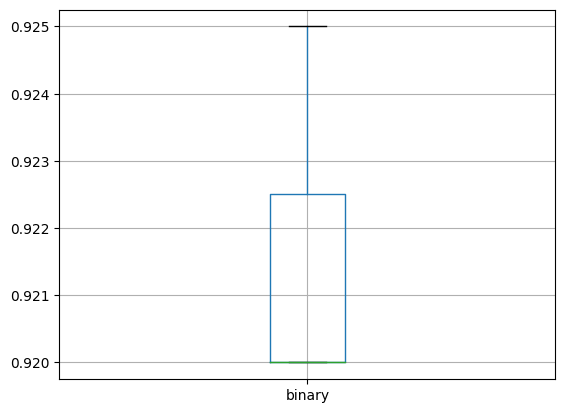

In [ ]:
# -*- coding: utf-8 -*-
"""Senti_MCP.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/119y59rnXQtP1r-JPl3S7i3ZNk_9ZcwYc
"""

from os import listdir
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.utils.vis_utils import plot_model
from pandas import DataFrame
from matplotlib import pyplot

import re

# load doc into memory
def load_doc(filename):
  # open the file as read only
  file = open(filename, 'r')
  # read all text
  text = file.read()
  # close the file
  file.close()
  return text

# turn a doc into clean tokens
def clean_doc(doc):
  # split into tokens by white space
  tokens = doc.split()
  # prepare regex for char filtering
  re_punc = re.compile( '[%s]' % re.escape(string.punctuation))
  # remove punctuation from each word
  tokens = [re_punc.sub('', w) for w in tokens]
  # remove remaining tokens that are not alphabetic
  tokens = [word for word in tokens if word.isalpha()]
  # filter out stop words
  stop_words = set(stopwords.words('english'))
  tokens = [w for w in tokens if not w in stop_words]
  # filter out short tokens
  tokens = [word for word in tokens if len(word) > 1]
  return tokens

# load doc, clean and return line of tokens
def doc_to_line(filename, vocab):
  # load the doc
  doc = load_doc(filename)
  # clean doc
  tokens = clean_doc(doc)
  # filter by vocab
  tokens = [w for w in tokens if w in vocab]
  return  ' '.join(tokens)

# load doc and add to vocab
def add_doc_to_vocab(filename, vocab):
  # load doc
  doc = load_doc(filename)
  # clean doc
  tokens = clean_doc(doc)
  # update counts
  vocab.update(tokens)

# load all docs in a directory
def process_docs(directory, vocab):
  lines = list()
  # walk through all files in the folder
  for filename in listdir(directory):
    # skip any reviews in the test set
    if filename.startswith('cv9'):
     continue
    '''
    # skip files that do not have the right extension
    if not filename.endswith(".txt"):
      next
    '''
    # create the full path of the file to open
    path = directory + '/' + filename
    # load and clean the doc
    line = doc_to_line(path, vocab)
    # add doc to vocab
    add_doc_to_vocab(path, vocab)

# save list to file
def save_list(lines, filename):
  data = '\n'.join(lines)
  file = open(filename, 'w')
  file.write(data)
  file.close()

# define vocab
vocab = Counter()
# add all docs to vocab
process_docs('/content/drive/MyDrive/txt_sentoken/neg', vocab)
process_docs('/content/drive/MyDrive/txt_sentoken/pos', vocab)
# print the size of the vocab
print(len(vocab))
# print the top words in the vocab
print(vocab.most_common(50))
# keep tokens with > 5 occurrence
min_occurrence = 2
tokens = [k for k,c in vocab.items() if c >= min_occurrence]
print(len(tokens))
# save tokens to a vocabulary file
save_list(tokens, '/content/vocab.txt')


def process_docs(directory, vocab,is_train):
  lines = list()
  # walk through all files in the folder
  for filename in listdir(directory):
    # skip any reviews in the test set
    if is_train and filename.startswith('cv9'):
     continue
    if not is_train and not filename.startswith('cv9'):
     continue
    '''
    # skip files that do not have the right extension
    if not filename.endswith(".txt"):
      next
    '''
    # create the full path of the file to open
    path = directory + '/' + filename
    # load and clean the doc
    line = doc_to_line(path, vocab)
    # add doc to vocab
    add_doc_to_vocab(path, vocab)
    #add to list
    lines.append(line);
  return lines;

#load vocabulary
vocab_filename = '/content/vocab.txt'
vocab = load_doc(vocab_filename);
vocab = vocab.split();
vocab = set(vocab);
#prepare negative reviews
negative_lines = process_docs('/content/drive/MyDrive/txt_sentoken/neg',vocab, True)
save_list(negative_lines,'negative.txt')

#prepare positive reviews
positive_lines = process_docs('/content/drive/MyDrive/txt_sentoken/pos',vocab, True)
save_list(positive_lines,'positive.txt')

#load and clean dataset
def load_clean_dataset(vocab,is_train):
  #load documents
  neg = process_docs('/content/drive/MyDrive/txt_sentoken/neg',vocab,is_train)
  pos = process_docs('/content/drive/MyDrive/txt_sentoken/pos',vocab,is_train)
  print("negative length "+str(len(neg))+" positive length "+str(len(pos)))
  docs = neg + pos
  #prepare labels
  labels = np.array([0 for _ in range (len(neg))] + [1 for _ in range(len(pos))])
  return docs,labels

#load all training reviews
docs, labels = load_clean_dataset(vocab, True)
#summarize what we have
print(len(docs),len(labels))

#fit a tokenizer
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

#laod vocab
vocab_filename = '/content/vocab.txt'
vocab = load_doc(vocab_filename)
print(str(len(vocab)))
vocab = set(vocab.split())
#load all reviews
train_doc, y_train = load_clean_dataset(vocab,True)
test_docs,y_test = load_clean_dataset(vocab,False)

#create Tokenizer
tokenizer = create_tokenizer(train_doc)

#encode the data
X_train = tokenizer.texts_to_matrix(train_doc,mode='binary')
X_test = tokenizer.texts_to_matrix(test_docs,mode='binary')
print(X_train.shape,X_test.shape)

def define_model(n_words):
  #define our network
  model = Sequential()
  model.add(Dense(50,input_shape= (n_words,),activation= 'relu'))
  model.add(Dense(1,activation= 'sigmoid'))
  #compile our network
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  #summarize the defined model
  model.summary()
  plot_model(model,to_file='model.png',show_shapes=True)
  return model
def evaluate_mode(Xtrain, ytrain, Xtest, ytest):
  scores = list()
  n_repeats = 3
  n_words = Xtest.shape[1]
  for i in range(n_repeats):
  # define network
    model = Sequential()
    model.add(Dense(50, input_shape=(n_words,), activation= 'relu'))
    model.add(Dense(1, activation= 'sigmoid' ))
    # compile network
    model.compile(loss= 'binary_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])
    # fit network
    model.fit(Xtrain, ytrain, epochs=10, verbose=2)
    # evaluate
    loss, acc = model.evaluate(Xtest, ytest, verbose=0)
    scores.append(acc)
    print( '%d accuracy: %s' % ((i+1), acc))
  return scores
def prepare_data(train_docs, test_docs, mode):
  # create the tokenizer
  tokenizer = Tokenizer()
  # fit the tokenizer on the documents
  tokenizer.fit_on_texts(train_docs)
  # encode training data set
  Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
  # encode training data set
  Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)
  return Xtrain, Xtest

#define the inputs
n_words = X_test.shape[1]
model = define_model(n_words)

#fit the network
model.fit(X_train,y_train,epochs= 10,verbose= 2)
history = model.fit(X_train,y_train,epochs= 10,verbose= 2)
#evaluate
loss,accuracy = model.evaluate(X_test,y_test,verbose=0)
print('Test Accuracy: %f' %(accuracy*100))




#test a negative text

train_docs, ytrain = load_clean_dataset(vocab, True)
test_docs, ytest = load_clean_dataset(vocab, False)
# run experiment
results = DataFrame()
Xtrain, Xtest = prepare_data(train_docs, test_docs, 'binary')
results['binary'] = evaluate_mode(Xtrain, ytrain, Xtest, ytest)
print(results.describe())
# plot results
results.boxplot()
pyplot.show()


In [ ]:
def predict_sentiment(review,vocab,tokenizer,model):
  #clean any review
  tokens = clean_doc(review)
  #filter vocab
  tokens = [w for w in tokens if w in vocab]
  #convert to line
  line = ' '.join(tokens)
  #encode(tokenize)
  encoded = tokenizer.texts_to_matrix([line],mode='binary')
  #predict sentiment
  yhat = model.predict(encoded,verbose=0)
  #retrieved predicted % and label

  percent_pos = yhat[0,0]
  if round(percent_pos) == 0:
    return (1-percent_pos),'NEGATIVE'
  return percent_pos,'POSITIVE'



In [ ]:
import pandas as pd
import re
frame = pd.read_csv('/content/drive/MyDrive/TCSS 456 NLP/Valorant.csv')
List = []
correct = 0
incorrect = 0
positive = 0
negative = 0
act_positive = 0
act_negative = 0

for tweet in frame['Text']:
  # if tweet.startswith('RT')
  #   index = tweet.find(':')
  #   for i in range(index)
  #     tweet[i] = ''

  tweet = re.sub(r'\bRT\b', '', tweet)

  # Remove Twitter handle and colon
  tweet = re.sub(r'@\w+:', '', tweet)

  # Remove hashtag
  tweet = re.sub(r'#\w+', '', tweet)


  Sent = predict_sentiment(tweet, vocab, tokenizer, model)
  tup = (tweet,Sent)
  List.append(tup)
for i in range(len(List)):

  if frame['Sentiment'][i] == 1:
    act_positive += 1
  else:
    act_negative += 1

  if List[i][1][1] == 'POSITIVE':
    tag = 1
    positive += 1
  else:
    tag = -1
    negative += 1
  if tag == frame['Sentiment'][i]:
    correct += 1
  else:
    incorrect += 1
print("correct: " + str(correct))
print("incorrect: " + str(incorrect))
print("model positive: " + str(positive))
print("mode negative: " + str(negative))
print("actual positive: " + str(act_positive))
print("actual negative: " + str(act_negative))


correct: 222
incorrect: 140
model positive: 78
mode negative: 284
actual positive: 142
actual negative: 220


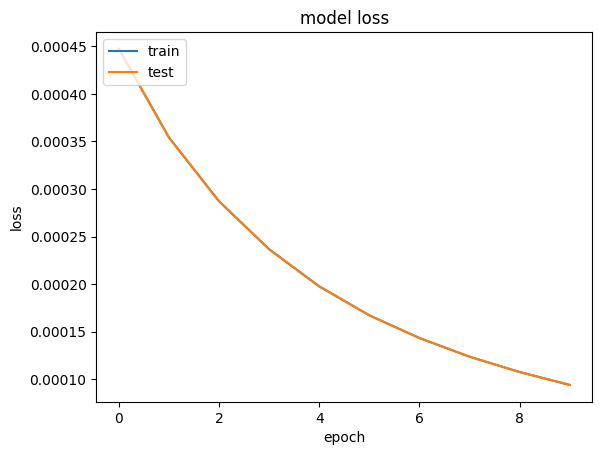

In [ ]:
# summarize history for loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()

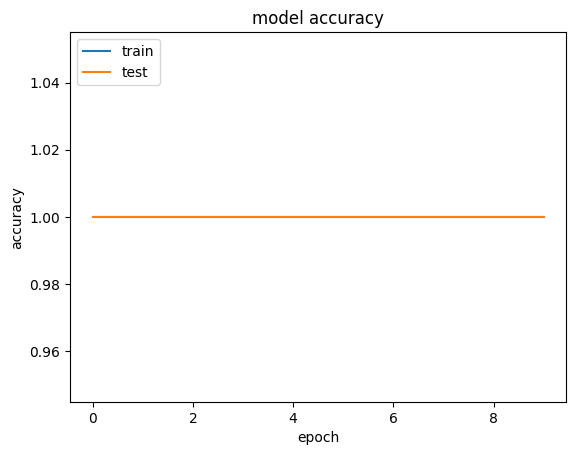

In [ ]:
pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['accuracy'])
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()